In [ ]:
# Ensure repo and src/ are importable and .env is loaded
import notebooks._bootstrap_src_path  # noqa: F401


# Retrieval Evaluation

In [ ]:
# Dependencies are managed via the repository's virtual environment.
# Install once from the project root using `requirements.txt`.
# This notebook intentionally avoids `%pip install` lines.

In [1]:
import os
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.dataclasses import ChatMessage
import importlib
from datetime import datetime
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import logging
from models import EmbeddingModelConfig, EmbeddingModelProvider, LLMConfig, LLMProvider, RerankingModelConfig, RerankingModelProvider, RewriterModelConfig
from pipelines.evaluation.base_retrieval_eval_pipeline import get_base_retrieval_eval_pipeline
logging.basicConfig(
    level=logging.WARNING,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S'
)
logging.getLogger("haystack").setLevel(logging.WARNING)

os.environ["SENTENCE_TRANSFORMERS_HOME"] = "./model-assets/sentence-transformers"
os.environ["HF_HUB_CACHE"] = "./model-assets/hugging-face"


In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from .env (bootstrap also does this; safe to call again)
load_dotenv()

# Ensure context size is set (models may use this downstream)
os.environ.setdefault("LLM_CONTEXT_SIZE", "8192")

NUMBER_OF_QUESTIONS_IN_EVAL = 600
TOP_K = 10

In [3]:
test_configs = [
    {
        "name": "Line",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
    },
]

In [4]:
now = datetime.now()

def run_retrieval_eval(filename, df):
    import config.prompt
    importlib.reload(config.prompt)

    import re

    match = re.search(r"answers_(.*?)_dataset", filename)
    if match:
        splitting_strategy = match.group(1)
    else:
        splitting_strategy = None

    # 1) Filter out the null‐question rows
    df_nonnull = df[df["question"].notnull()]

    df_shuffled = df_nonnull.sample(n=NUMBER_OF_QUESTIONS_IN_EVAL, random_state=42).reset_index(drop=True)

    for index, row in tqdm(
        df_shuffled.iterrows(),
        total=len(df_shuffled),
        desc="Processing rows",
        unit="row"
    ):
        for test_config in test_configs:
            relevant_documents = row["documents"]
            question = row["question"]

            index_store = InMemoryDocumentStore.load_from_disk(f"data/document_stores/{test_config['embedding_model'].name}/base/{splitting_strategy}_indexing_store.json")
            pipeline = get_base_retrieval_eval_pipeline(
                index_store, 
                test_config["embedding_model"], 
                None, 
                None,
            )
            request_payload = {
                "retriever": {
                    "top_k": TOP_K,
                },
                "map_evaluator": {
                    "ground_truth_documents": [relevant_documents],
                },
                "mrr_evaluator": {
                    "ground_truth_documents": [relevant_documents],
                },
                "recall_evaluator": {
                    "ground_truth_documents": [relevant_documents],
                }
            }
            request_payload["query_embedder"] = {
                "text": question,
            }
            result = pipeline.run(request_payload)

            map_score = result.get("map_evaluator", {}).get("score", {})
            mrr_score = result.get("mrr_evaluator", {}).get("score", {})
            recall_score = result.get("recall_evaluator", {}).get("score", {})

            print(recall_score)

            df.at[index, f"{test_config['name']}_map"] = map_score
            df.at[index, f"{test_config['name']}_mrr"] = mrr_score
            df.at[index, f"{test_config['name']}_recall"] = recall_score

    save_path = f"results/retrieval/line_paragraph/{now.strftime('%Y-%m-%d_%H-%M-%S')}/{splitting_strategy}.pkl"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    df.to_pickle(save_path)

# run_retrieval_eval("data/qa_with_docs_flat/question_answers_docs_line_1_0_dataset_flat.pkl", pd.read_pickle("data/qa_with_docs_flat/question_answers_docs_line_1_0_dataset_flat.pkl"))
# run_retrieval_eval("data/qa_with_docs_flat/question_answers_docs_word_31_6_dataset_flat.pkl", pd.read_pickle("data/qa_with_docs_flat/question_answers_docs_word_31_6_dataset_flat.pkl"))
# run_retrieval_eval("data/qa_with_docs_flat/question_answers_docs_passage_1_0_dataset_flat.pkl", pd.read_pickle("data/qa_with_docs_flat/question_answers_docs_passage_1_0_dataset_flat.pkl"))
run_retrieval_eval("data/qa_with_docs_flat/question_answers_docs_word_41_8_dataset_flat.pkl", pd.read_pickle("data/qa_with_docs_flat/question_answers_docs_word_41_8_dataset_flat.pkl"))

Processing rows:   0%|          | 0/600 [00:00<?, ?row/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   0%|          | 1/600 [00:08<1:26:02,  8.62s/row]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   0%|          | 2/600 [00:09<39:00,  3.91s/row]  

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   0%|          | 3/600 [00:09<23:55,  2.40s/row]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   1%|          | 4/600 [00:10<16:47,  1.69s/row]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   1%|          | 5/600 [00:11<12:51,  1.30s/row]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   1%|          | 6/600 [00:11<10:28,  1.06s/row]

0.23809523809523808


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   1%|          | 7/600 [00:12<08:57,  1.10row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   1%|▏         | 8/600 [00:12<07:58,  1.24row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   2%|▏         | 9/600 [00:13<07:20,  1.34row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   2%|▏         | 10/600 [00:14<06:56,  1.42row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   2%|▏         | 11/600 [00:14<06:45,  1.45row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   2%|▏         | 12/600 [00:15<06:33,  1.49row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   2%|▏         | 13/600 [00:15<06:22,  1.53row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   2%|▏         | 14/600 [00:16<06:13,  1.57row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   2%|▎         | 15/600 [00:17<06:05,  1.60row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   3%|▎         | 16/600 [00:17<05:58,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   3%|▎         | 17/600 [00:18<05:54,  1.64row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   3%|▎         | 18/600 [00:18<05:56,  1.63row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   3%|▎         | 19/600 [00:19<05:55,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   3%|▎         | 20/600 [00:20<05:55,  1.63row/s]

0.36363636363636365


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   4%|▎         | 21/600 [00:20<05:51,  1.65row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   4%|▎         | 22/600 [00:21<05:48,  1.66row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   4%|▍         | 23/600 [00:21<05:45,  1.67row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   4%|▍         | 24/600 [00:22<05:44,  1.67row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   4%|▍         | 25/600 [00:23<05:42,  1.68row/s]

0.2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   4%|▍         | 26/600 [00:23<05:42,  1.68row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   4%|▍         | 27/600 [00:24<05:41,  1.68row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   5%|▍         | 28/600 [00:24<05:41,  1.68row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   5%|▍         | 29/600 [00:25<05:39,  1.68row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   5%|▌         | 30/600 [00:26<05:44,  1.65row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   5%|▌         | 31/600 [00:26<05:44,  1.65row/s]

0.4


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   5%|▌         | 32/600 [00:27<05:43,  1.66row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   6%|▌         | 33/600 [00:27<05:40,  1.66row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   6%|▌         | 34/600 [00:28<05:40,  1.66row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   6%|▌         | 35/600 [00:29<05:39,  1.67row/s]

0.42857142857142855


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   6%|▌         | 36/600 [00:29<05:38,  1.67row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   6%|▌         | 37/600 [00:30<05:37,  1.67row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   6%|▋         | 38/600 [00:30<05:43,  1.64row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   6%|▋         | 39/600 [00:31<05:44,  1.63row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   7%|▋         | 40/600 [00:32<05:42,  1.64row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   7%|▋         | 41/600 [00:32<05:40,  1.64row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   7%|▋         | 42/600 [00:33<05:38,  1.65row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   7%|▋         | 43/600 [00:34<05:36,  1.66row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   7%|▋         | 44/600 [00:34<05:34,  1.66row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 45/600 [00:35<05:34,  1.66row/s]

0.3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 46/600 [00:35<05:33,  1.66row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 47/600 [00:36<05:31,  1.67row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 48/600 [00:37<05:36,  1.64row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 49/600 [00:37<05:35,  1.64row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 50/600 [00:38<05:36,  1.64row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 51/600 [00:38<05:37,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   9%|▊         | 52/600 [00:39<05:37,  1.62row/s]

0.23809523809523808


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   9%|▉         | 53/600 [00:40<05:36,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   9%|▉         | 54/600 [00:40<05:34,  1.63row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   9%|▉         | 55/600 [00:41<05:36,  1.62row/s]

0.5714285714285714


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   9%|▉         | 56/600 [00:41<05:35,  1.62row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  10%|▉         | 57/600 [00:42<05:32,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  10%|▉         | 58/600 [00:43<05:29,  1.64row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  10%|▉         | 59/600 [00:43<05:28,  1.65row/s]

0.2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  10%|█         | 60/600 [00:44<05:27,  1.65row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  10%|█         | 61/600 [00:44<05:25,  1.66row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  10%|█         | 62/600 [00:45<05:28,  1.64row/s]

0.3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  10%|█         | 63/600 [00:46<05:27,  1.64row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  11%|█         | 64/600 [00:46<05:27,  1.64row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  11%|█         | 65/600 [00:47<05:25,  1.64row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  11%|█         | 66/600 [00:48<05:24,  1.64row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  11%|█         | 67/600 [00:48<05:23,  1.65row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  11%|█▏        | 68/600 [00:49<05:24,  1.64row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  12%|█▏        | 69/600 [00:49<05:28,  1.62row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  12%|█▏        | 70/600 [00:50<05:24,  1.63row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  12%|█▏        | 71/600 [00:51<05:22,  1.64row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  12%|█▏        | 72/600 [00:51<05:21,  1.64row/s]

0.2857142857142857


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  12%|█▏        | 73/600 [00:52<05:23,  1.63row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  12%|█▏        | 74/600 [00:52<05:24,  1.62row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  12%|█▎        | 75/600 [00:53<05:21,  1.63row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  13%|█▎        | 76/600 [00:54<05:19,  1.64row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  13%|█▎        | 77/600 [00:54<05:18,  1.64row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  13%|█▎        | 78/600 [00:55<05:17,  1.65row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  13%|█▎        | 79/600 [00:55<05:16,  1.65row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  13%|█▎        | 80/600 [00:56<05:16,  1.64row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  14%|█▎        | 81/600 [00:57<05:13,  1.65row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  14%|█▎        | 82/600 [00:57<05:12,  1.66row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  14%|█▍        | 83/600 [00:58<05:11,  1.66row/s]

0.42857142857142855


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  14%|█▍        | 84/600 [00:58<05:11,  1.66row/s]

0.36363636363636365


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  14%|█▍        | 85/600 [00:59<05:10,  1.66row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  14%|█▍        | 86/600 [01:00<05:12,  1.64row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  14%|█▍        | 87/600 [01:00<05:11,  1.65row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  15%|█▍        | 88/600 [01:01<05:11,  1.64row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  15%|█▍        | 89/600 [01:02<05:09,  1.65row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  15%|█▌        | 90/600 [01:02<05:07,  1.66row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  15%|█▌        | 91/600 [01:03<05:08,  1.65row/s]

0.058823529411764705


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  15%|█▌        | 92/600 [01:03<05:06,  1.66row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  16%|█▌        | 93/600 [01:04<05:09,  1.64row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  16%|█▌        | 94/600 [01:05<05:08,  1.64row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  16%|█▌        | 95/600 [01:05<05:06,  1.65row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  16%|█▌        | 96/600 [01:06<05:06,  1.64row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  16%|█▌        | 97/600 [01:06<05:05,  1.65row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  16%|█▋        | 98/600 [01:07<05:04,  1.65row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  16%|█▋        | 99/600 [01:08<05:11,  1.61row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  17%|█▋        | 100/600 [01:08<05:10,  1.61row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  17%|█▋        | 101/600 [01:09<05:09,  1.61row/s]

0.7142857142857143


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  17%|█▋        | 102/600 [01:10<05:12,  1.59row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  17%|█▋        | 103/600 [01:10<05:13,  1.58row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  17%|█▋        | 104/600 [01:11<05:08,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  18%|█▊        | 105/600 [01:11<05:06,  1.61row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  18%|█▊        | 106/600 [01:12<05:04,  1.62row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  18%|█▊        | 107/600 [01:13<05:02,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  18%|█▊        | 108/600 [01:13<05:01,  1.63row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  18%|█▊        | 109/600 [01:14<05:00,  1.63row/s]

0.2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  18%|█▊        | 110/600 [01:14<04:58,  1.64row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  18%|█▊        | 111/600 [01:15<04:56,  1.65row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  19%|█▊        | 112/600 [01:16<04:55,  1.65row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  19%|█▉        | 113/600 [01:16<04:54,  1.66row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  19%|█▉        | 114/600 [01:17<04:58,  1.63row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  19%|█▉        | 115/600 [01:17<04:56,  1.63row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  19%|█▉        | 116/600 [01:18<04:55,  1.64row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  20%|█▉        | 117/600 [01:19<04:53,  1.64row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  20%|█▉        | 118/600 [01:19<04:53,  1.64row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  20%|█▉        | 119/600 [01:20<04:58,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  20%|██        | 120/600 [01:21<05:03,  1.58row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  20%|██        | 121/600 [01:21<04:59,  1.60row/s]

0.11764705882352941


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  20%|██        | 122/600 [01:22<04:56,  1.61row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  20%|██        | 123/600 [01:22<04:54,  1.62row/s]

0.3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  21%|██        | 124/600 [01:23<04:51,  1.63row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  21%|██        | 125/600 [01:24<04:51,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  21%|██        | 126/600 [01:24<04:49,  1.64row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  21%|██        | 127/600 [01:25<04:49,  1.63row/s]

0.2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  21%|██▏       | 128/600 [01:25<04:49,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  22%|██▏       | 129/600 [01:26<04:49,  1.62row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  22%|██▏       | 130/600 [01:27<04:48,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  22%|██▏       | 131/600 [01:27<04:47,  1.63row/s]

0.23809523809523808


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  22%|██▏       | 132/600 [01:28<04:46,  1.63row/s]

0.4


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  22%|██▏       | 133/600 [01:29<04:50,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  22%|██▏       | 134/600 [01:29<04:48,  1.62row/s]

0.36363636363636365


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  22%|██▎       | 135/600 [01:30<04:45,  1.63row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  23%|██▎       | 136/600 [01:30<04:44,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  23%|██▎       | 137/600 [01:31<04:43,  1.63row/s]

0.8


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  23%|██▎       | 138/600 [01:32<04:42,  1.64row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  23%|██▎       | 139/600 [01:32<04:41,  1.64row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  23%|██▎       | 140/600 [01:33<04:40,  1.64row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  24%|██▎       | 141/600 [01:34<04:46,  1.60row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  24%|██▎       | 142/600 [01:34<04:49,  1.58row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  24%|██▍       | 143/600 [01:35<04:46,  1.59row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  24%|██▍       | 144/600 [01:35<04:43,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  24%|██▍       | 145/600 [01:36<04:42,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  24%|██▍       | 146/600 [01:37<04:40,  1.62row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  24%|██▍       | 147/600 [01:37<04:40,  1.62row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  25%|██▍       | 148/600 [01:38<04:37,  1.63row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  25%|██▍       | 149/600 [01:38<04:40,  1.61row/s]

0.8


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  25%|██▌       | 150/600 [01:39<04:39,  1.61row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  25%|██▌       | 151/600 [01:40<04:37,  1.62row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  25%|██▌       | 152/600 [01:40<04:37,  1.62row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  26%|██▌       | 153/600 [01:41<04:35,  1.62row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  26%|██▌       | 154/600 [01:42<04:33,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  26%|██▌       | 155/600 [01:42<04:33,  1.63row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  26%|██▌       | 156/600 [01:43<04:32,  1.63row/s]

0.058823529411764705


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  26%|██▌       | 157/600 [01:43<04:31,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  26%|██▋       | 158/600 [01:44<04:31,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  26%|██▋       | 159/600 [01:45<04:30,  1.63row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  27%|██▋       | 160/600 [01:45<04:29,  1.63row/s]

0.36363636363636365


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  27%|██▋       | 161/600 [01:46<04:29,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  27%|██▋       | 162/600 [01:46<04:28,  1.63row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  27%|██▋       | 163/600 [01:47<04:28,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  27%|██▋       | 164/600 [01:48<04:27,  1.63row/s]

0.1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  28%|██▊       | 165/600 [01:48<04:27,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  28%|██▊       | 166/600 [01:49<04:25,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  28%|██▊       | 167/600 [01:50<04:25,  1.63row/s]

0.3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  28%|██▊       | 168/600 [01:50<04:24,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  28%|██▊       | 169/600 [01:51<04:23,  1.64row/s]

0.058823529411764705


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  28%|██▊       | 170/600 [01:51<04:23,  1.63row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  28%|██▊       | 171/600 [01:52<04:23,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  29%|██▊       | 172/600 [01:53<04:25,  1.61row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  29%|██▉       | 173/600 [01:53<04:25,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  29%|██▉       | 174/600 [01:54<04:23,  1.62row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  29%|██▉       | 175/600 [01:54<04:22,  1.62row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  29%|██▉       | 176/600 [01:55<04:22,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  30%|██▉       | 177/600 [01:56<04:21,  1.62row/s]

0.5714285714285714


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  30%|██▉       | 178/600 [01:56<04:20,  1.62row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  30%|██▉       | 179/600 [01:57<04:19,  1.63row/s]

0.42857142857142855


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  30%|███       | 180/600 [01:58<04:18,  1.63row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  30%|███       | 181/600 [01:58<04:18,  1.62row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  30%|███       | 182/600 [01:59<04:17,  1.62row/s]

0.4


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  30%|███       | 183/600 [01:59<04:17,  1.62row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  31%|███       | 184/600 [02:00<04:16,  1.62row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  31%|███       | 185/600 [02:01<04:16,  1.62row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  31%|███       | 186/600 [02:01<04:15,  1.62row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  31%|███       | 187/600 [02:02<04:14,  1.62row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  31%|███▏      | 188/600 [02:02<04:13,  1.63row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  32%|███▏      | 189/600 [02:03<04:12,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  32%|███▏      | 190/600 [02:04<04:10,  1.63row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  32%|███▏      | 191/600 [02:04<04:10,  1.63row/s]

0.4


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  32%|███▏      | 192/600 [02:05<04:10,  1.63row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  32%|███▏      | 193/600 [02:06<04:10,  1.63row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  32%|███▏      | 194/600 [02:06<04:09,  1.63row/s]

0.7142857142857143


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  32%|███▎      | 195/600 [02:07<04:09,  1.62row/s]

0.7142857142857143


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  33%|███▎      | 196/600 [02:07<04:10,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  33%|███▎      | 197/600 [02:08<04:13,  1.59row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  33%|███▎      | 198/600 [02:09<04:12,  1.60row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  33%|███▎      | 199/600 [02:09<04:10,  1.60row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  33%|███▎      | 200/600 [02:10<04:09,  1.61row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  34%|███▎      | 201/600 [02:11<04:08,  1.61row/s]

0.1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  34%|███▎      | 202/600 [02:11<04:07,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  34%|███▍      | 203/600 [02:12<04:06,  1.61row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  34%|███▍      | 204/600 [02:12<04:06,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  34%|███▍      | 205/600 [02:13<04:04,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  34%|███▍      | 206/600 [02:14<04:04,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  34%|███▍      | 207/600 [02:14<04:03,  1.61row/s]

0.7142857142857143


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  35%|███▍      | 208/600 [02:15<04:05,  1.60row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  35%|███▍      | 209/600 [02:16<04:03,  1.60row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  35%|███▌      | 210/600 [02:16<04:02,  1.61row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  35%|███▌      | 211/600 [02:17<04:01,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  35%|███▌      | 212/600 [02:17<04:01,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  36%|███▌      | 213/600 [02:18<04:00,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  36%|███▌      | 214/600 [02:19<03:59,  1.61row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  36%|███▌      | 215/600 [02:19<03:58,  1.61row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  36%|███▌      | 216/600 [02:20<03:58,  1.61row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  36%|███▌      | 217/600 [02:20<03:56,  1.62row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  36%|███▋      | 218/600 [02:21<03:57,  1.61row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  36%|███▋      | 219/600 [02:22<04:07,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  37%|███▋      | 220/600 [02:22<04:08,  1.53row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  37%|███▋      | 221/600 [02:23<04:06,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  37%|███▋      | 222/600 [02:24<04:05,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  37%|███▋      | 223/600 [02:24<04:02,  1.56row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  37%|███▋      | 224/600 [02:25<04:03,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  38%|███▊      | 225/600 [02:26<04:02,  1.54row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  38%|███▊      | 226/600 [02:26<03:59,  1.56row/s]

0.058823529411764705


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  38%|███▊      | 227/600 [02:27<03:57,  1.57row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  38%|███▊      | 228/600 [02:28<03:56,  1.57row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  38%|███▊      | 229/600 [02:28<03:54,  1.58row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  38%|███▊      | 230/600 [02:29<03:53,  1.59row/s]

0.45454545454545453


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  38%|███▊      | 231/600 [02:29<03:52,  1.59row/s]

0.7142857142857143


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  39%|███▊      | 232/600 [02:30<03:51,  1.59row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  39%|███▉      | 233/600 [02:31<03:50,  1.59row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  39%|███▉      | 234/600 [02:31<03:48,  1.60row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  39%|███▉      | 235/600 [02:32<03:49,  1.59row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  39%|███▉      | 236/600 [02:33<04:00,  1.51row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  40%|███▉      | 237/600 [02:33<03:59,  1.52row/s]

0.1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  40%|███▉      | 238/600 [02:34<04:04,  1.48row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  40%|███▉      | 239/600 [02:35<03:57,  1.52row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  40%|████      | 240/600 [02:35<03:52,  1.55row/s]

0.5714285714285714


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  40%|████      | 241/600 [02:36<03:48,  1.57row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  40%|████      | 242/600 [02:37<03:45,  1.58row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  40%|████      | 243/600 [02:37<03:43,  1.60row/s]

0.3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  41%|████      | 244/600 [02:38<03:42,  1.60row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  41%|████      | 245/600 [02:38<03:41,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  41%|████      | 246/600 [02:39<03:40,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  41%|████      | 247/600 [02:40<03:38,  1.61row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  41%|████▏     | 248/600 [02:40<03:38,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  42%|████▏     | 249/600 [02:41<03:38,  1.61row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  42%|████▏     | 250/600 [02:42<03:39,  1.59row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  42%|████▏     | 251/600 [02:42<03:37,  1.60row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  42%|████▏     | 252/600 [02:43<03:44,  1.55row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  42%|████▏     | 253/600 [02:43<03:42,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  42%|████▏     | 254/600 [02:44<03:40,  1.57row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  42%|████▎     | 255/600 [02:45<03:41,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  43%|████▎     | 256/600 [02:45<03:38,  1.57row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  43%|████▎     | 257/600 [02:46<03:36,  1.58row/s]

0.047619047619047616


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  43%|████▎     | 258/600 [02:47<03:36,  1.58row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  43%|████▎     | 259/600 [02:47<03:38,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  43%|████▎     | 260/600 [02:48<03:36,  1.57row/s]

0.058823529411764705


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  44%|████▎     | 261/600 [02:49<03:34,  1.58row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  44%|████▎     | 262/600 [02:49<03:32,  1.59row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  44%|████▍     | 263/600 [02:50<03:30,  1.60row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  44%|████▍     | 264/600 [02:50<03:28,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  44%|████▍     | 265/600 [02:51<03:27,  1.61row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  44%|████▍     | 266/600 [02:52<03:26,  1.62row/s]

0.6


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  44%|████▍     | 267/600 [02:52<03:25,  1.62row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  45%|████▍     | 268/600 [02:53<03:25,  1.62row/s]

0.2857142857142857


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  45%|████▍     | 269/600 [02:53<03:25,  1.61row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  45%|████▌     | 270/600 [02:54<03:25,  1.61row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  45%|████▌     | 271/600 [02:55<03:27,  1.59row/s]

0.5714285714285714


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  45%|████▌     | 272/600 [02:55<03:27,  1.58row/s]

0.7142857142857143


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  46%|████▌     | 273/600 [02:56<03:26,  1.58row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  46%|████▌     | 274/600 [02:57<03:25,  1.59row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  46%|████▌     | 275/600 [02:57<03:25,  1.59row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  46%|████▌     | 276/600 [02:58<03:26,  1.57row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  46%|████▌     | 277/600 [02:59<03:26,  1.57row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  46%|████▋     | 278/600 [02:59<03:25,  1.57row/s]

0.5714285714285714


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  46%|████▋     | 279/600 [03:00<03:24,  1.57row/s]

0.36363636363636365


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  47%|████▋     | 280/600 [03:00<03:22,  1.58row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  47%|████▋     | 281/600 [03:01<03:22,  1.58row/s]

0.8


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  47%|████▋     | 282/600 [03:02<03:21,  1.58row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  47%|████▋     | 283/600 [03:02<03:20,  1.58row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  47%|████▋     | 284/600 [03:03<03:20,  1.57row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 285/600 [03:04<03:19,  1.58row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 286/600 [03:04<03:18,  1.58row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 287/600 [03:05<03:18,  1.58row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 288/600 [03:06<03:18,  1.57row/s]

0.36363636363636365


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 289/600 [03:06<03:21,  1.55row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 290/600 [03:07<03:21,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 291/600 [03:08<03:21,  1.54row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  49%|████▊     | 292/600 [03:08<03:20,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  49%|████▉     | 293/600 [03:09<03:17,  1.56row/s]

0.2857142857142857


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  49%|████▉     | 294/600 [03:09<03:15,  1.57row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  49%|████▉     | 295/600 [03:10<03:13,  1.58row/s]

0.2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  49%|████▉     | 296/600 [03:11<03:11,  1.59row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 297/600 [03:11<03:10,  1.59row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 298/600 [03:12<03:09,  1.60row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 299/600 [03:13<03:08,  1.60row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 300/600 [03:13<03:07,  1.60row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 301/600 [03:14<03:06,  1.60row/s]

0.19047619047619047


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 302/600 [03:14<03:06,  1.60row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 303/600 [03:15<03:05,  1.60row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  51%|█████     | 304/600 [03:16<03:07,  1.58row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  51%|█████     | 305/600 [03:16<03:05,  1.59row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  51%|█████     | 306/600 [03:17<03:09,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  51%|█████     | 307/600 [03:18<03:11,  1.53row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  51%|█████▏    | 308/600 [03:18<03:08,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 309/600 [03:19<03:06,  1.56row/s]

0.8333333333333334


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 310/600 [03:20<03:04,  1.57row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 311/600 [03:20<03:04,  1.57row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 312/600 [03:21<03:03,  1.57row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 313/600 [03:21<03:02,  1.57row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 314/600 [03:22<03:01,  1.58row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  52%|█████▎    | 315/600 [03:23<03:00,  1.58row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 316/600 [03:23<02:59,  1.58row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 317/600 [03:24<02:58,  1.58row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 318/600 [03:25<02:57,  1.59row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 319/600 [03:25<02:57,  1.58row/s]

0.14285714285714285


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 320/600 [03:26<02:58,  1.57row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  54%|█████▎    | 321/600 [03:27<02:57,  1.57row/s]

0.1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  54%|█████▎    | 322/600 [03:27<02:57,  1.57row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 323/600 [03:28<02:56,  1.57row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 324/600 [03:28<02:59,  1.54row/s]

0.3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 325/600 [03:29<02:59,  1.53row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 326/600 [03:30<02:57,  1.54row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 327/600 [03:30<02:56,  1.55row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 328/600 [03:31<02:56,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 329/600 [03:32<02:55,  1.54row/s]

0.23529411764705882


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 330/600 [03:32<02:54,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 331/600 [03:33<02:52,  1.56row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 332/600 [03:34<02:51,  1.56row/s]

0.7142857142857143


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 333/600 [03:34<02:50,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 334/600 [03:35<02:49,  1.57row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 335/600 [03:36<02:51,  1.54row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 336/600 [03:36<02:51,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 337/600 [03:37<02:50,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 338/600 [03:37<02:48,  1.55row/s]

0.36363636363636365


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 339/600 [03:38<02:46,  1.57row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 340/600 [03:39<02:44,  1.58row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 341/600 [03:39<02:44,  1.57row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 342/600 [03:40<02:43,  1.58row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 343/600 [03:41<02:44,  1.56row/s]

0.8


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 344/600 [03:41<02:43,  1.56row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  57%|█████▊    | 345/600 [03:42<02:43,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 346/600 [03:43<02:42,  1.57row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 347/600 [03:43<02:41,  1.57row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 348/600 [03:44<02:41,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 349/600 [03:44<02:40,  1.57row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 350/600 [03:45<02:39,  1.57row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 351/600 [03:46<02:37,  1.58row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 352/600 [03:46<02:36,  1.58row/s]

0.8333333333333334


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 353/600 [03:47<02:36,  1.58row/s]

0.23809523809523808


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 354/600 [03:48<02:35,  1.58row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 355/600 [03:48<02:35,  1.57row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 356/600 [03:49<02:39,  1.53row/s]

0.8571428571428571


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 357/600 [03:50<02:38,  1.53row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 358/600 [03:50<02:38,  1.52row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 359/600 [03:51<02:40,  1.50row/s]

0.8


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 360/600 [03:52<02:41,  1.49row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 361/600 [03:52<02:39,  1.50row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 362/600 [03:53<02:37,  1.51row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 363/600 [03:54<02:36,  1.52row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 364/600 [03:54<02:35,  1.51row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 365/600 [03:55<02:33,  1.53row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 366/600 [03:56<02:31,  1.54row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 367/600 [03:56<02:30,  1.55row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 368/600 [03:57<02:29,  1.55row/s]

0.1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 369/600 [03:58<02:31,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 370/600 [03:58<02:29,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 371/600 [03:59<02:29,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 372/600 [03:59<02:28,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 373/600 [04:00<02:27,  1.54row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 374/600 [04:01<02:26,  1.54row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  62%|██████▎   | 375/600 [04:01<02:25,  1.55row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 376/600 [04:02<02:25,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 377/600 [04:03<02:24,  1.55row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 378/600 [04:03<02:23,  1.55row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 379/600 [04:04<02:22,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 380/600 [04:05<02:22,  1.54row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 381/600 [04:05<02:22,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 382/600 [04:06<02:21,  1.54row/s]

0.7142857142857143


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 383/600 [04:07<02:21,  1.53row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 384/600 [04:07<02:20,  1.53row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 385/600 [04:08<02:20,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 386/600 [04:09<02:19,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 387/600 [04:09<02:18,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 388/600 [04:10<02:18,  1.53row/s]

0.7142857142857143


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 389/600 [04:11<02:17,  1.53row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 390/600 [04:11<02:17,  1.53row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 391/600 [04:12<02:16,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 392/600 [04:12<02:15,  1.53row/s]

0.2857142857142857


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 393/600 [04:13<02:17,  1.51row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 394/600 [04:14<02:15,  1.52row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 395/600 [04:14<02:13,  1.54row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 396/600 [04:15<02:11,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 397/600 [04:16<02:10,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 398/600 [04:16<02:09,  1.56row/s]

0.1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 399/600 [04:17<02:09,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 400/600 [04:18<02:09,  1.55row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 401/600 [04:18<02:08,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 402/600 [04:19<02:09,  1.53row/s]

0.14285714285714285


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 403/600 [04:20<02:08,  1.53row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 404/600 [04:20<02:08,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 405/600 [04:21<02:07,  1.53row/s]

0.14285714285714285


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 406/600 [04:22<02:06,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 407/600 [04:22<02:04,  1.55row/s]

0.42857142857142855


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 408/600 [04:23<02:03,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 409/600 [04:24<02:04,  1.54row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 410/600 [04:24<02:03,  1.53row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 411/600 [04:25<02:01,  1.55row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 412/600 [04:25<02:01,  1.55row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 413/600 [04:26<02:00,  1.56row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 414/600 [04:27<01:59,  1.56row/s]

0.42857142857142855


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 415/600 [04:27<01:58,  1.56row/s]

0.058823529411764705


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 416/600 [04:28<01:57,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 417/600 [04:29<01:56,  1.57row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 418/600 [04:29<01:56,  1.57row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 419/600 [04:30<01:55,  1.57row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 420/600 [04:31<01:55,  1.55row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 421/600 [04:31<01:55,  1.55row/s]

0.5714285714285714


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 422/600 [04:32<01:54,  1.55row/s]

0.2857142857142857


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 423/600 [04:33<01:54,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 424/600 [04:33<01:52,  1.56row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 425/600 [04:34<01:52,  1.56row/s]

0.8


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 426/600 [04:34<01:51,  1.56row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 427/600 [04:35<01:52,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 428/600 [04:36<01:50,  1.55row/s]

0.5714285714285714


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 429/600 [04:36<01:50,  1.55row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 430/600 [04:37<01:49,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 431/600 [04:38<01:48,  1.56row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 432/600 [04:38<01:46,  1.57row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 433/600 [04:39<01:46,  1.57row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 434/600 [04:40<01:45,  1.57row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  72%|███████▎  | 435/600 [04:40<01:45,  1.56row/s]

0.11764705882352941


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 436/600 [04:41<01:44,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 437/600 [04:41<01:44,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 438/600 [04:42<01:43,  1.56row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 439/600 [04:43<01:42,  1.56row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 440/600 [04:43<01:42,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 441/600 [04:44<01:41,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 442/600 [04:45<01:43,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 443/600 [04:45<01:42,  1.53row/s]

0.2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 444/600 [04:46<01:41,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 445/600 [04:47<01:40,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 446/600 [04:47<01:39,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 447/600 [04:48<01:39,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  75%|███████▍  | 448/600 [04:49<01:38,  1.54row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  75%|███████▍  | 449/600 [04:49<01:38,  1.53row/s]

0.1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  75%|███████▌  | 450/600 [04:50<01:38,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  75%|███████▌  | 451/600 [04:51<01:36,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  75%|███████▌  | 452/600 [04:51<01:36,  1.54row/s]

0.4


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  76%|███████▌  | 453/600 [04:52<01:35,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  76%|███████▌  | 454/600 [04:53<01:35,  1.54row/s]

0.42857142857142855


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  76%|███████▌  | 455/600 [04:53<01:33,  1.55row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  76%|███████▌  | 456/600 [04:54<01:33,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  76%|███████▌  | 457/600 [04:54<01:32,  1.54row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  76%|███████▋  | 458/600 [04:55<01:31,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  76%|███████▋  | 459/600 [04:56<01:31,  1.55row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  77%|███████▋  | 460/600 [04:56<01:30,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  77%|███████▋  | 461/600 [04:57<01:30,  1.54row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  77%|███████▋  | 462/600 [04:58<01:29,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  77%|███████▋  | 463/600 [04:58<01:28,  1.54row/s]

0.23809523809523808


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  77%|███████▋  | 464/600 [04:59<01:28,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  78%|███████▊  | 465/600 [05:00<01:27,  1.54row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  78%|███████▊  | 466/600 [05:00<01:28,  1.52row/s]

0.3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  78%|███████▊  | 467/600 [05:01<01:27,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  78%|███████▊  | 468/600 [05:02<01:26,  1.53row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  78%|███████▊  | 469/600 [05:02<01:25,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  78%|███████▊  | 470/600 [05:03<01:24,  1.54row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  78%|███████▊  | 471/600 [05:04<01:23,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  79%|███████▊  | 472/600 [05:04<01:22,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  79%|███████▉  | 473/600 [05:05<01:22,  1.55row/s]

0.5714285714285714


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  79%|███████▉  | 474/600 [05:06<01:22,  1.52row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  79%|███████▉  | 475/600 [05:06<01:22,  1.52row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  79%|███████▉  | 476/600 [05:07<01:21,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  80%|███████▉  | 477/600 [05:07<01:20,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  80%|███████▉  | 478/600 [05:08<01:18,  1.55row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  80%|███████▉  | 479/600 [05:09<01:18,  1.54row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  80%|████████  | 480/600 [05:09<01:17,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  80%|████████  | 481/600 [05:10<01:16,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  80%|████████  | 482/600 [05:11<01:16,  1.55row/s]

0.7142857142857143


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  80%|████████  | 483/600 [05:11<01:15,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  81%|████████  | 484/600 [05:12<01:15,  1.55row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  81%|████████  | 485/600 [05:13<01:14,  1.55row/s]

0.5714285714285714


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  81%|████████  | 486/600 [05:13<01:13,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  81%|████████  | 487/600 [05:14<01:12,  1.56row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  81%|████████▏ | 488/600 [05:15<01:11,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  82%|████████▏ | 489/600 [05:15<01:11,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  82%|████████▏ | 490/600 [05:16<01:10,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  82%|████████▏ | 491/600 [05:17<01:11,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  82%|████████▏ | 492/600 [05:17<01:10,  1.54row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  82%|████████▏ | 493/600 [05:18<01:09,  1.54row/s]

0.2727272727272727


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  82%|████████▏ | 494/600 [05:18<01:08,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  82%|████████▎ | 495/600 [05:19<01:07,  1.54row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  83%|████████▎ | 496/600 [05:20<01:07,  1.55row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  83%|████████▎ | 497/600 [05:20<01:06,  1.55row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  83%|████████▎ | 498/600 [05:21<01:05,  1.55row/s]

0.3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  83%|████████▎ | 499/600 [05:22<01:05,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  83%|████████▎ | 500/600 [05:22<01:04,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  84%|████████▎ | 501/600 [05:23<01:03,  1.56row/s]

0.2857142857142857


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  84%|████████▎ | 502/600 [05:24<01:02,  1.56row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  84%|████████▍ | 503/600 [05:24<01:02,  1.55row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  84%|████████▍ | 504/600 [05:25<01:01,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  84%|████████▍ | 505/600 [05:26<01:01,  1.56row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  84%|████████▍ | 506/600 [05:26<01:00,  1.56row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  84%|████████▍ | 507/600 [05:27<00:59,  1.56row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  85%|████████▍ | 508/600 [05:27<00:58,  1.56row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  85%|████████▍ | 509/600 [05:28<00:58,  1.56row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  85%|████████▌ | 510/600 [05:29<00:57,  1.56row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  85%|████████▌ | 511/600 [05:29<00:57,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  85%|████████▌ | 512/600 [05:30<00:56,  1.56row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  86%|████████▌ | 513/600 [05:31<00:56,  1.55row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  86%|████████▌ | 514/600 [05:31<00:55,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  86%|████████▌ | 515/600 [05:32<00:54,  1.56row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  86%|████████▌ | 516/600 [05:33<00:54,  1.55row/s]

0.2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  86%|████████▌ | 517/600 [05:33<00:53,  1.54row/s]

0.7142857142857143


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  86%|████████▋ | 518/600 [05:34<00:53,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  86%|████████▋ | 519/600 [05:35<00:52,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  87%|████████▋ | 520/600 [05:35<00:51,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  87%|████████▋ | 521/600 [05:36<00:51,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  87%|████████▋ | 522/600 [05:36<00:50,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  87%|████████▋ | 523/600 [05:37<00:49,  1.55row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  87%|████████▋ | 524/600 [05:38<00:49,  1.55row/s]

0.7142857142857143


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  88%|████████▊ | 525/600 [05:38<00:48,  1.55row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  88%|████████▊ | 526/600 [05:39<00:47,  1.55row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  88%|████████▊ | 527/600 [05:40<00:47,  1.54row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  88%|████████▊ | 528/600 [05:40<00:46,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  88%|████████▊ | 529/600 [05:41<00:46,  1.54row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  88%|████████▊ | 530/600 [05:42<00:45,  1.55row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  88%|████████▊ | 531/600 [05:42<00:44,  1.55row/s]

0.25


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  89%|████████▊ | 532/600 [05:43<00:43,  1.55row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  89%|████████▉ | 533/600 [05:44<00:43,  1.55row/s]

0.19047619047619047


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  89%|████████▉ | 534/600 [05:44<00:42,  1.55row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  89%|████████▉ | 535/600 [05:45<00:41,  1.55row/s]

0.5714285714285714


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  89%|████████▉ | 536/600 [05:46<00:41,  1.55row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  90%|████████▉ | 537/600 [05:46<00:40,  1.55row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  90%|████████▉ | 538/600 [05:47<00:40,  1.54row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  90%|████████▉ | 539/600 [05:47<00:39,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  90%|█████████ | 540/600 [05:48<00:38,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  90%|█████████ | 541/600 [05:49<00:38,  1.55row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  90%|█████████ | 542/600 [05:49<00:37,  1.55row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  90%|█████████ | 543/600 [05:50<00:36,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  91%|█████████ | 544/600 [05:51<00:37,  1.50row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  91%|█████████ | 545/600 [05:51<00:36,  1.50row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  91%|█████████ | 546/600 [05:52<00:35,  1.52row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  91%|█████████ | 547/600 [05:53<00:34,  1.52row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  91%|█████████▏| 548/600 [05:53<00:34,  1.52row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  92%|█████████▏| 549/600 [05:54<00:33,  1.52row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  92%|█████████▏| 550/600 [05:55<00:32,  1.52row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  92%|█████████▏| 551/600 [05:55<00:32,  1.53row/s]

0.3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  92%|█████████▏| 552/600 [05:56<00:31,  1.53row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  92%|█████████▏| 553/600 [05:57<00:30,  1.53row/s]

0.2727272727272727


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  92%|█████████▏| 554/600 [05:57<00:30,  1.53row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  92%|█████████▎| 555/600 [05:58<00:29,  1.52row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  93%|█████████▎| 556/600 [05:59<00:29,  1.51row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  93%|█████████▎| 557/600 [05:59<00:28,  1.51row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  93%|█████████▎| 558/600 [06:00<00:27,  1.52row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  93%|█████████▎| 559/600 [06:01<00:27,  1.52row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  93%|█████████▎| 560/600 [06:01<00:26,  1.52row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  94%|█████████▎| 561/600 [06:02<00:25,  1.52row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  94%|█████████▎| 562/600 [06:03<00:24,  1.53row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  94%|█████████▍| 563/600 [06:03<00:24,  1.52row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  94%|█████████▍| 564/600 [06:04<00:23,  1.52row/s]

0.2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  94%|█████████▍| 565/600 [06:05<00:22,  1.52row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  94%|█████████▍| 566/600 [06:05<00:22,  1.52row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  94%|█████████▍| 567/600 [06:06<00:21,  1.52row/s]

0.5714285714285714


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  95%|█████████▍| 568/600 [06:07<00:21,  1.50row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  95%|█████████▍| 569/600 [06:07<00:20,  1.51row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  95%|█████████▌| 570/600 [06:08<00:19,  1.52row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  95%|█████████▌| 571/600 [06:09<00:19,  1.52row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  95%|█████████▌| 572/600 [06:09<00:18,  1.52row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  96%|█████████▌| 573/600 [06:10<00:17,  1.52row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  96%|█████████▌| 574/600 [06:10<00:17,  1.53row/s]

0.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  96%|█████████▌| 575/600 [06:11<00:16,  1.51row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  96%|█████████▌| 576/600 [06:12<00:15,  1.52row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  96%|█████████▌| 577/600 [06:12<00:15,  1.52row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  96%|█████████▋| 578/600 [06:13<00:14,  1.53row/s]

0.3333333333333333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  96%|█████████▋| 579/600 [06:14<00:13,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  97%|█████████▋| 580/600 [06:14<00:12,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  97%|█████████▋| 581/600 [06:15<00:12,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  97%|█████████▋| 582/600 [06:16<00:11,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  97%|█████████▋| 583/600 [06:16<00:11,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  97%|█████████▋| 584/600 [06:17<00:10,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  98%|█████████▊| 585/600 [06:18<00:09,  1.51row/s]

0.3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  98%|█████████▊| 586/600 [06:18<00:09,  1.52row/s]

0.42857142857142855


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  98%|█████████▊| 587/600 [06:19<00:08,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  98%|█████████▊| 588/600 [06:20<00:07,  1.54row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  98%|█████████▊| 589/600 [06:20<00:07,  1.54row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  98%|█████████▊| 590/600 [06:21<00:06,  1.53row/s]

0.75


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  98%|█████████▊| 591/600 [06:22<00:05,  1.53row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  99%|█████████▊| 592/600 [06:22<00:05,  1.53row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  99%|█████████▉| 593/600 [06:23<00:04,  1.54row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  99%|█████████▉| 594/600 [06:24<00:03,  1.54row/s]

0.2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  99%|█████████▉| 595/600 [06:24<00:03,  1.53row/s]

0.8


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  99%|█████████▉| 596/600 [06:25<00:02,  1.51row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows: 100%|█████████▉| 597/600 [06:26<00:01,  1.50row/s]

1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows: 100%|█████████▉| 598/600 [06:26<00:01,  1.50row/s]

0.6666666666666666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows: 100%|█████████▉| 599/600 [06:27<00:00,  1.50row/s]

0.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows: 100%|██████████| 600/600 [06:28<00:00,  1.55row/s]

1.0


## Analysis

/tmp/ipykernel_3684568/1717171947.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=0, color="black")
/tmp/ipykernel_3684568/1717171947.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=0, color="black")
/tmp/ipykernel_3684568/1717171947.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=0, color="black")


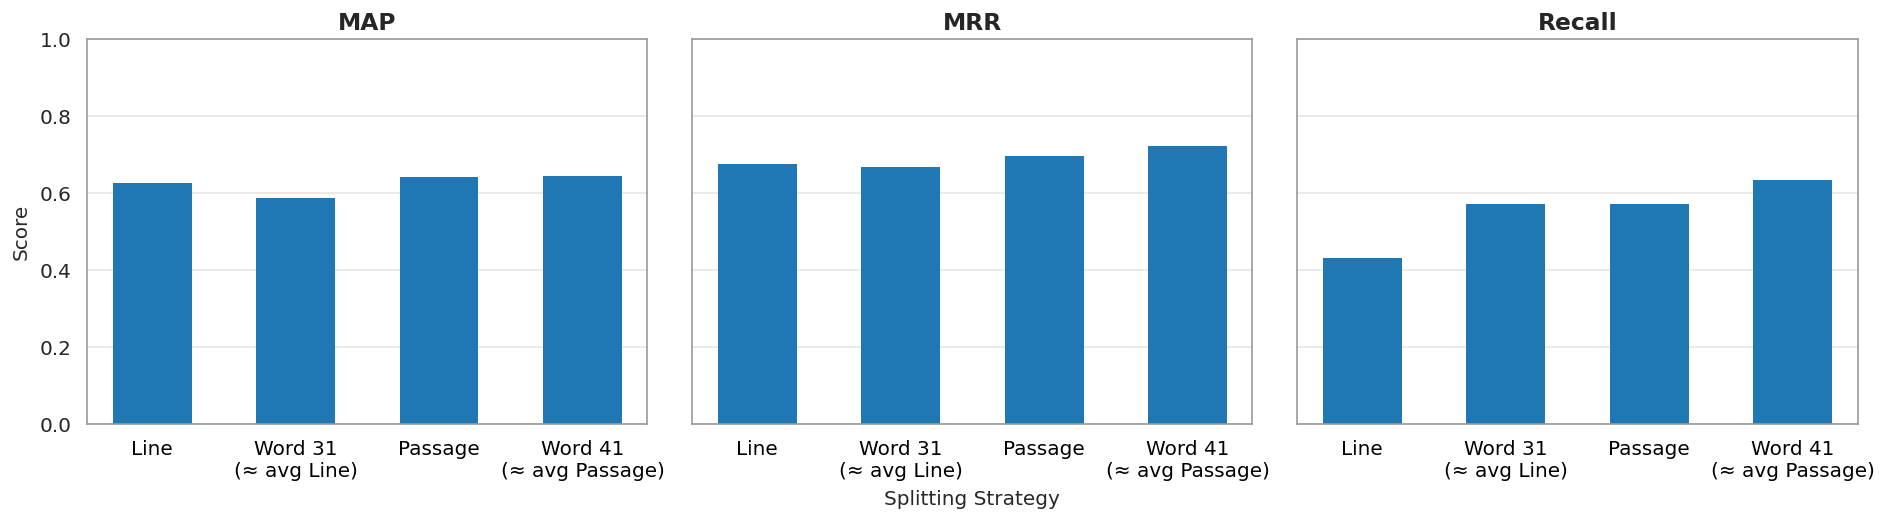

,label,MAP,MRR,Recall
0,Line,0.626877,0.675024,0.432384
1,Word 31\n(≈ avg Line),0.586114,0.666752,0.571613
2,Passage,0.642046,0.696155,0.572049
3,Word 41\n(≈ avg Passage),0.644321,0.722888,0.634103


In [22]:
# Compare splitting strategies from the latest line_paragraph results
# and plot one bar chart per metric with the same style/colors as the rewriter analysis
import os
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import display

# --- Style settings (mirroring the rewriter analysis) ---
BASIC_RAG_COLOR = "#1f77b4"  # uniform bar color
sns.set(style="whitegrid")
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "axes.labelweight": "bold",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.dpi": 120,
})

base_dir = Path("results/retrieval/line_paragraph")

if not base_dir.exists() or not any(base_dir.iterdir()):
    raise FileNotFoundError(f"No results found under {base_dir}. Run retrieval first.")

# Find latest timestamped folder
subdirs = [d for d in base_dir.iterdir() if d.is_dir()]
if not subdirs:
    raise FileNotFoundError(f"No timestamped result folders found in {base_dir}.")

# Parse folder names as datetimes when possible, otherwise use mtime fallback

def parse_dt(p: Path):
    try:
        return datetime.strptime(p.name, "%Y-%m-%d_%H-%M-%S")
    except Exception:
        # fallback: filesystem modified time
        return datetime.fromtimestamp(p.stat().st_mtime)

latest_dir = max(subdirs, key=parse_dt)

# Load all pkl files in the latest dir
pkl_files = sorted(latest_dir.glob("*.pkl"))
if not pkl_files:
    raise FileNotFoundError(f"No .pkl files found in {latest_dir}.")

rows = []
for pkl in pkl_files:
    try:
        df = pd.read_pickle(pkl)
    except Exception as e:
        print(f"Skipping {pkl.name}: {e}")
        continue

    # Infer splitting strategy from filename (e.g., docs_word_41_8.pkl)
    splitting_strategy = pkl.stem

    # Try to find metric columns (support prefixes like 'Line_map')
    map_cols = [c for c in df.columns if c.lower().endswith("_map")] or [c for c in df.columns if c.lower() == "map"]
    mrr_cols = [c for c in df.columns if c.lower().endswith("_mrr")] or [c for c in df.columns if c.lower() == "mrr"]
    recall_cols = [c for c in df.columns if c.lower().endswith("_recall")] or [c for c in df.columns if c.lower() == "recall"]

    if not (map_cols and mrr_cols and recall_cols):
        print(f"Warning: Expected metric columns not found in {pkl.name}.")
        continue

    # Compute means (ignore NaNs). If multiple systems are present, average them per row first.
    map_mean = df[map_cols].select_dtypes(include=["number"]).mean(axis=1).mean()
    mrr_mean = df[mrr_cols].select_dtypes(include=["number"]).mean(axis=1).mean()
    recall_mean = df[recall_cols].select_dtypes(include=["number"]).mean(axis=1).mean()

    rows.append({
        "splitting_strategy": splitting_strategy,
        "MAP": float(map_mean) if pd.notna(map_mean) else None,
        "MRR": float(mrr_mean) if pd.notna(mrr_mean) else None,
        "Recall": float(recall_mean) if pd.notna(recall_mean) else None,
    })

if not rows:
    raise RuntimeError("No valid metrics aggregated. Check that result files contain *_map, *_mrr, *_recall columns.")

summary_df = pd.DataFrame(rows)

# Map to friendly labels and enforce desired order: line, word 31, passage, word 41
# Use substring checks to be robust to prefixes like 'docs_word_31_...'

def label_and_order(name: str):
    low = name.lower()
    if "line" in low:
        return "Line", 0
    if "word_31" in low:
        # Word-split equivalent to average line length
        return "Word 31\n(≈ avg Line)", 1
    if "passage" in low:
        return "Passage", 2
    if "word_41" in low:
        # Word-split equivalent to average passage length
        return "Word 41\n(≈ avg Passage)", 3
    # Unknowns go after known ones, keep original name as label
    return name, 100

summary_df[["label", "order"]] = summary_df["splitting_strategy"].apply(lambda n: pd.Series(label_and_order(n)))

# Sort by the custom order (keep unknowns at the end)
summary_df = summary_df.sort_values(by=["order"], ascending=[True]).reset_index(drop=True)

# Plot one figure with three horizontal subplots (one per metric), sharing y-axis
metrics = ["MAP", "MRR", "Recall"]
fig, axes = plt.subplots(1, len(metrics), figsize=(16, 4.5), sharey=True)

x = summary_df["label"].tolist()
for idx, (ax, metric) in enumerate(zip(axes, metrics)):
    y = summary_df[metric].tolist()

    # Bars colored with BASIC_RAG_COLOR, consistent width
    ax.bar(x, y, color=BASIC_RAG_COLOR, width=0.55, edgecolor='none')

    # Titles and labels
    ax.set_title(metric)
    # Only label the middle (center) chart on x-axis
    if idx == 1:
        ax.set_xlabel("Splitting Strategy", fontweight='normal', labelpad=5)
    else:
        ax.set_xlabel("")

    # Only label the left chart on y-axis for cleanliness
    if idx == 0:
        ax.set_ylabel("Score", fontweight='normal', labelpad=5)
    else:
        ax.set_ylabel("")

    ax.set_ylim(0, 1)
    ax.set_xticklabels(x, rotation=0, color="black")

    # Grid & spines: only horizontal grid lines, with a full box around each plot
    ax.set_axisbelow(True)
    ax.grid(axis='y', color='0.9', linestyle='-', linewidth=1)
    ax.grid(axis='x', visible=False)

    # Ensure a box around each subplot (similar to reranker)
    for side in ['top', 'right', 'bottom', 'left']:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(1)
        ax.spines[side].set_color('0.6')

# Spacing similar to rewriter-style multi-panel figures, but tighter
fig.tight_layout()
fig.subplots_adjust(wspace=0.08)
plt.show()

# Display the summary table below the charts for reference
display(summary_df[["label", "MAP", "MRR", "Recall"]])